### Analyse the dendrograms made to explain what contacts are responsible for the splitting. 

This is a follow up to the analysis performed in the notebook called "network_similarity.ipynb". 

In that notebook, hierarchal clustering was performed, and in this one we analyse what caused the splitting. 

### Part 0: Setup

In [1]:
import re
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio

from kin.msa_indexing import parse_fasta, clean_up_sequence, parse_contact_output, indexing_pdb_to_msa
from kin.pymol_projections import project_pymol_res_res_scores

# Constants.
MSA_SEQUENCES_FILE = r"../src/tests/data/bettaLac.ali"
TEM1_FITNESS_DF = r"tem1_fitness_data/per_mutation_fitness.csv"
TARGET_PROTEIN = "1M40_TEM-1"
TEM1_RES_RES_SCORES_FILE = r"../contact_analysis/static_contacts_processing/shared_network/network_tem1_pdb.csv"
TEM1_RES_RES_MD_SCORES_FILES = {
    "0% Cutoff" :r"../contact_analysis/dynamic_contacts_processing/shared_network/network_tem1_pdb_0.csv",
    "10% Cutoff" :r"../contact_analysis/dynamic_contacts_processing/shared_network/network_tem1_pdb_10.csv",
    "50% Cutoff" :r"../contact_analysis/dynamic_contacts_processing/shared_network/network_tem1_pdb_50.csv",
    "90% Cutoff" :r"../contact_analysis/dynamic_contacts_processing/shared_network/network_tem1_pdb_90.csv",
    "95% Cutoff" :r"../contact_analysis/dynamic_contacts_processing/shared_network/network_tem1_pdb_95.csv",
}

In [2]:
all_msa_seqs = parse_fasta(MSA_SEQUENCES_FILE)

all_msa_contacs_dfs = {}
for protein in all_msa_seqs.keys():
    contacts_path = fr"../contact_analysis/crystal_contacts/{protein}.txt"
    seq, short_seq = clean_up_sequence(all_msa_seqs, protein)
    pdb_df_crystal = parse_contact_output(contacts_path, contact_type="crystal")
    msa_df_crystal = indexing_pdb_to_msa(seq, pdb_df_crystal)

    all_msa_contacs_dfs[protein] = msa_df_crystal

convert from current form to one single format where the msa residues are a column. and 1 or 0 for each protein
Protein is a row...

In [3]:
all_msa_res_pairs = {"protein":[]}
for idx, (protein, df) in enumerate(all_msa_contacs_dfs.items()):
    all_msa_res_pairs["protein"].append(protein)

    df_no_vdw = df[ df["Interaction_Type"] != "vdw" ]
    prot_res_pairs = list(zip(df_no_vdw["Res1_msa"], df_no_vdw["Res2_msa"]))

    for res_pair in prot_res_pairs:
        if res_pair in all_msa_res_pairs:
            all_msa_res_pairs[res_pair][idx] = 1
        else: # create list of 0s if not already exists..
             all_msa_res_pairs[res_pair] = [0] * len(all_msa_contacs_dfs)
             all_msa_res_pairs[res_pair][idx] = 1


all_msa_contacts = pd.DataFrame(all_msa_res_pairs)
all_msa_contacts

,protein,"(5, 16)","(13, 17)","(14, 18)","(15, 19)","(16, 20)","(17, 21)","(17, 285)","(18, 22)","(19, 23)",...,"(109, 111)","(5, 21)","(9, 11)","(10, 281)","(11, 30)","(20, 28)","(22, 67)","(24, 26)","(26, 56)","(204, 252)"
0,1BSG_SAL-1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1BUE_NmcA,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1DY6_SME-1,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1E25_PER-1,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1G6A_PSE-4,0,1,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,6WJM_DBA-1,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
65,7A6Z_BlaC-13,0,0,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
66,7BDR_CTX-M-15,0,0,0,0,0,0,0,1,1,...,1,0,0,0,0,0,0,0,0,0
67,7DDM_PenA-39,0,0,0,0,0,0,0,0,0,...,0,1,1,1,0,0,0,0,0,0


### Part 1: Add a classification label describing how the dendrogram split each structure. 
This is based on the 2nd split of the phyllogenetic tree. Some structures (5) were already not included at this point in the dendrogram, they are refered to as other_pdb_ids 

In [4]:
# assingments made from clustering, all others belong to cluster2
proteins = list(all_msa_contacs_dfs.keys())
other_pdb_ids = ["4EWF", "3ZNW", "5TFQ", "1E25", "6PQ9"]
cluster1_pdb_ids = ["3W4Q", "6BU3", "3P09", "1BSG", "2CC1", "3BFF", "5VPQ", "6W2Z", "4MXG", "7QLP",]

other_proteins = []
for pdb_id in other_pdb_ids:
    matching_proteins = [search_string for search_string in proteins if pdb_id in search_string]
    if len(matching_proteins) != 1:
        raise ValueError("Search not specific enough, need new approach")
    else:
        other_proteins.append(matching_proteins[0])

cluster1_proteins = []
for pdb_id in cluster1_pdb_ids:
    matching_proteins = [search_string for search_string in proteins if pdb_id in search_string]
    if len(matching_proteins) != 1:
        raise ValueError("Search not specific enough, need new approach")
    else:
        cluster1_proteins.append(matching_proteins[0])

# cluster2 can be defined by not being in either of the above 2 groups.
cluster2_proteins = []
for protein in all_msa_contacs_dfs:
    if protein not in (other_proteins + cluster1_proteins):
        cluster2_proteins.append(protein)

# total = 69 which is expected.
f"{len(cluster1_proteins)=} {len(cluster2_proteins)=} {len(other_proteins)=}"

'len(cluster1_proteins)=10 len(cluster2_proteins)=54 len(other_proteins)=5'

In [5]:
cluster_assingments = []
for protein in all_msa_contacts["protein"]:
    if protein in cluster1_proteins:
        cluster_assingments.append("Cluster 1")
    elif protein in cluster2_proteins:
        cluster_assingments.append("Cluster 2")
    else:
        cluster_assingments.append("Other")

all_msa_contacts.insert(loc=0, column="Cluster", value=cluster_assingments)
# filter out the non cluster ones.
all_msa_contacts = all_msa_contacts[all_msa_contacts["Cluster"] != "Other"]
all_msa_contacts.head(3)

,Cluster,protein,"(5, 16)","(13, 17)","(14, 18)","(15, 19)","(16, 20)","(17, 21)","(17, 285)","(18, 22)",...,"(109, 111)","(5, 21)","(9, 11)","(10, 281)","(11, 30)","(20, 28)","(22, 67)","(24, 26)","(26, 56)","(204, 252)"
0,Cluster 1,1BSG_SAL-1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,Cluster 2,1BUE_NmcA,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,Cluster 2,1DY6_SME-1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


### Part 2: Now do some basic counting to find the interactions which differ the most between the groups

In [6]:
cluster1_counts = dict(all_msa_contacts[all_msa_contacts["Cluster"] == "Cluster 1"].drop(["protein", "Cluster"], axis=1).mean(axis=0))
cluster2_counts = dict(all_msa_contacts[all_msa_contacts["Cluster"] == "Cluster 2"].drop(["protein", "Cluster"], axis=1).mean(axis=0))
cluster1_counts[(65, 206)], cluster2_counts[(65, 206)]

(0.3, 0.7962962962962963)

In [7]:
cluster_diffs, cluster_ab_diffs = {}, {}
for msa_pair, cluster1_count in cluster1_counts.items():
    cluster2_count = cluster2_counts[msa_pair]
    diff = np.round((cluster2_count - cluster1_count), 2)
    abs_diff = np.abs(diff)

    cluster_diffs[msa_pair] = diff
    cluster_ab_diffs[msa_pair] = abs_diff
cluster_diffs = {k: v for k, v in sorted(cluster_diffs.items(), key=lambda item: item[1], reverse=True)} # sort by value
cluster_ab_diffs = {k: v for k, v in sorted(cluster_ab_diffs.items(), key=lambda item: item[1], reverse=True)} # sort by value
print(len(cluster_diffs))

1758


make a histogram of the difference in convservation for each contact between the two groups 

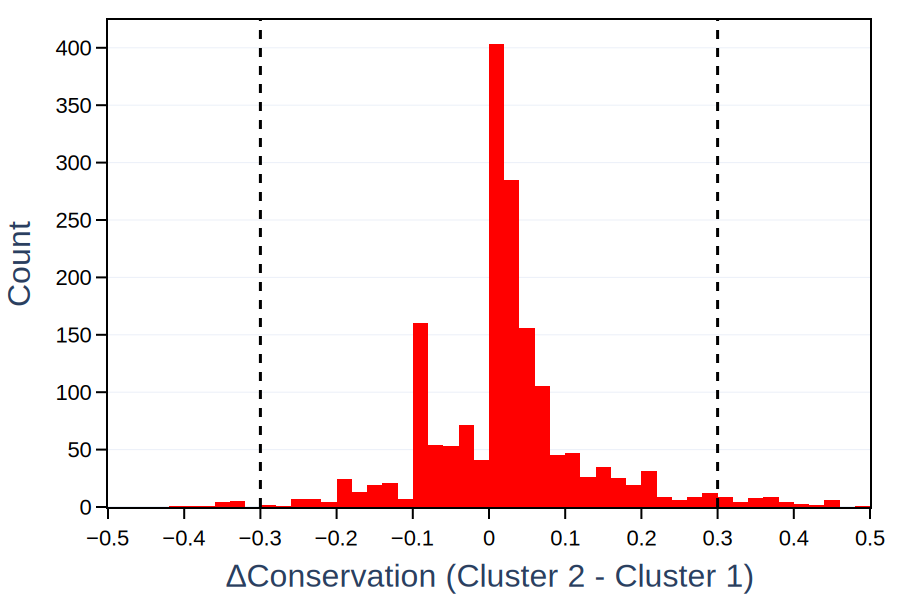

In [8]:
fig = px.histogram(x=list(cluster_diffs.values()), nbins=50, color_discrete_sequence=["red"])

fig.update_layout(
    template="plotly_white",
    yaxis=dict(title="Count", titlefont=dict(size=32)),
    xaxis=dict(title="ΔConservation (Cluster 2 - Cluster 1)", titlefont=dict(size=32)),
    margin=dict(l=20, r=20, t=20, b=20),
    showlegend=False,
    font_family="Arial",
    width=900,
    height=600,
    xaxis_range=[-0.5,0.5]
)

fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True,
                 ticks="outside", tickwidth=2, tickcolor='black', ticklen=10,
                 tickvals = [-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5],
                 tickfont=dict(color='black', size=22))
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True,
                 ticks="outside", tickwidth=2, tickcolor='black', ticklen=10,
                 tickfont=dict(color='black', size=22))

fig.add_vline(x=0.3, line_width=3, line_dash="dash", line_color="black")
fig.add_vline(x=-0.3, line_width=3, line_dash="dash", line_color="black")
pio.write_image(fig, r"comparison_results/Hist_cluster_contact_diffs.png", scale=6)
fig.show("svg") # remove "svg" to make the figure interactive.

### Part 3: Using a cutoff of 0.3 on either side, find a good represenative protein of each structure and show the found contacts

In [9]:
count_not_included, count_included = 0, 0
cluster1_stronger, cluster2_stronger = {}, {}
for msa_pair, diff in cluster_diffs.items():
    if diff > 0.3: # stronger in cluster 2...
        cluster2_stronger[msa_pair] = diff
        count_included += 1
    elif diff < -0.3: # stronger in cluster 1...
        cluster1_stronger[msa_pair] = diff
        count_included += 1
    else:
        count_not_included += 1

print(count_included, count_not_included)

57 1701


find a protein that has most of the contacts needed

In [10]:
clust1_df = all_msa_contacts[all_msa_contacts["Cluster"] == "Cluster 1"]
clust2_df = all_msa_contacts[all_msa_contacts["Cluster"] == "Cluster 2"]
clust1_df.head()

,Cluster,protein,"(5, 16)","(13, 17)","(14, 18)","(15, 19)","(16, 20)","(17, 21)","(17, 285)","(18, 22)",...,"(109, 111)","(5, 21)","(9, 11)","(10, 281)","(11, 30)","(20, 28)","(22, 67)","(24, 26)","(26, 56)","(204, 252)"
0,Cluster 1,1BSG_SAL-1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
11,Cluster 1,2CC1_MFO-1,1,1,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
17,Cluster 1,3BFF_SED-1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
20,Cluster 1,3P09_FTU-2,0,1,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
27,Cluster 1,3W4Q_PenA-1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Below bit of code says which structure is best to project the results onto, i.e., which has one has most of the shared interactions

In [11]:
clust1_matches = {}
for _, protein_row in clust1_df.iterrows():
    protein = protein_row["protein"]
    match_count = 0
    for msa_pair in list(cluster1_stronger.keys()):
        match_count += protein_row[msa_pair] # value is 1 or 0 depending on if exists.
    clust1_matches[protein] = match_count
clust1_matches  = {k: v for k, v in sorted(clust1_matches.items(), key=lambda item: item[1], reverse=True)} # sort by value

clust2_matches = {}
for _, protein_row in clust2_df.iterrows():
    protein = protein_row["protein"]
    match_count = 0
    for msa_pair in list(cluster2_stronger.keys()):
        match_count += protein_row[msa_pair] # value is 1 or 0 depending on if exists.
    clust2_matches[protein] = match_count
clust2_matches  = {k: v for k, v in sorted(clust2_matches.items(), key=lambda item: item[1], reverse=True)} # sort by value
print(clust1_matches)
print(clust2_matches)

{'2CC1_MFO-1': 12, '5VPQ_BPA-1': 12, '4MXG_BEL-1': 11, '1BSG_SAL-1': 10, '3P09_FTU-2': 10, '3W4Q_PenA-1': 5, '3BFF_SED-1': 4, '7QLP_TEM-171': 4, '6BU3_CTX-M-27': 3, '6W2Z_BAA-83': 3}
{'6QWB_KPC-4': 38, '6WGP_XCC-2': 37, '5GHX_PenP-1': 35, '6MK6_VCC-1': 35, '6QWA_KPC-3': 35, '6W34_BcI-248': 35, '1DY6_SME-1': 34, '2WK0_PenP-2': 34, '5NE2_L2-2': 34, '6NJ1_CKA-1': 34, '6WJM_DBA-1': 34, '4EUZ_SFC-1': 33, '6TD0_KPC-2': 33, '3QHY_BcI-2': 32, '1BUE_NmcA': 31, '3LEZ_OIH-1': 31, '6MU9_PenP-4': 31, '4YFM_MAB-1': 30, '5E43_SROS-1': 30, '1GHP_PC1-1': 29, '6WIP_MIA-1': 29, '6WGR_PC1-159': 28, '2P74_CTX-M-9': 27, '3W4P_BPS-1d': 26, '7A6Z_BlaC-13': 26, '5NJ2_BlaC': 25, '7DDM_PenA-39': 25, '2ZQ7_CTX-M-44': 24, '4UA6_CTX-M-14': 24, '5E2E_BlaA': 24, '5F82_GES-5': 24, '1HZO_K1': 23, '3TSG_GES-14': 23, '3V3R_GES-11': 23, '3V3S_GES-18': 23, '3ZNY_CTX-M-96': 23, '4QU3_GES-2': 23, '6AFM_BPS-3': 23, '7BDR_CTX-M-15': 23, '1YLW_CTX-M-16': 22, '6BN3_CTX-M-151': 22, '6J25_CTX-M-64': 22, '1G6A_PSE-4': 21, '1M40_TEM

### Part 4: Make output for PyMOL (to project results onto the structure)

In [12]:
PYMOL_COLOR_SCHEME = {
    "hbond": "br1",
    "saltbridge": "dash",
    "hydrophobic": "br9",
    "pipi": "br5",
    "cationpi": "brightorange",
    "vdw": "green"
}

cluster_1_rep_pdb = "2CC1_MFO-1"
cluster_2_rep_pdb = "6QWB_KPC-4"

# absolute value needed for pymol projections.
cluster1_stronger = {key: np.abs(value) for key, value in cluster1_stronger.items()}

In [13]:
# The selected cluster 1 protein has all the contacts needed, so no filtering needed.
cluster1_res_res_scores, cluster1_res_res_colors = {}, {}
for msa_pair, diff in cluster1_stronger.items():
    msa_res1, msa_res2 = msa_pair
    contact_row = all_msa_contacs_dfs["2CC1_MFO-1"].query(f"Res1_msa == {msa_res1} & Res2_msa == {msa_res2} & not Interaction_Type.str.contains('vdw')").iloc[0]
    res1, res2, interaction_type = contact_row[["Res1_pdb", "Res2_pdb", "Interaction_Type"]]
    res1_numb = int(re.search(r"\d+", res1).group())
    res2_numb = int(re.search(r"\d+", res2).group())

    cluster1_res_res_scores[(res1_numb, res2_numb)] = diff
    cluster1_res_res_colors[(res1_numb, res2_numb)] = PYMOL_COLOR_SCHEME[interaction_type]


cluster2_res_res_scores, cluster2_res_res_colors = {}, {}
for msa_pair, diff in cluster2_stronger.items():
    msa_res1, msa_res2 = msa_pair
    try:
        contact_row = all_msa_contacs_dfs["6QWB_KPC-4"].query(f"Res1_msa == {msa_res1} & Res2_msa == {msa_res2} & not Interaction_Type.str.contains('vdw')").iloc[0]
    except IndexError:
        # protein does not have all the msa_contacts, just most of them,
        # expected behaviour.
        continue
    res1, res2, interaction_type = contact_row[["Res1_pdb", "Res2_pdb", "Interaction_Type"]]
    res1_numb = int(re.search(r"\d+", res1).group())
    res2_numb = int(re.search(r"\d+", res2).group())

    cluster2_res_res_scores[(res1_numb, res2_numb)] = diff
    cluster2_res_res_colors[(res1_numb, res2_numb)] = PYMOL_COLOR_SCHEME[interaction_type]

f"{len(cluster1_res_res_scores)=} {len(cluster2_res_res_scores)=}"

'len(cluster1_res_res_scores)=12 len(cluster2_res_res_scores)=38'

In [14]:
# write out results
project_pymol_res_res_scores(
    res_res_scores=cluster1_res_res_scores,
    out_file=r"comparison_results/pymol_stronger_cluster1.pml",
    res_res_colors=cluster1_res_res_colors,
)

project_pymol_res_res_scores(
    res_res_scores=cluster2_res_res_scores,
    out_file=r"comparison_results/pymol_stronger_cluster2.pml",
    res_res_colors=cluster2_res_res_colors,
)

The file: comparison_results/pymol_stronger_cluster1.pml was written to disk.
The file: comparison_results/pymol_stronger_cluster2.pml was written to disk.


### Part 5: Do the exact same as above but for the first split (that gives rise to 5 structures only)

In [15]:
# group of 5 that are most different.
most_diff_pdb_ids = ["4EWF", "3ZNW", "5TFQ", "1E25", "6PQ9"]

most_diff_proteins = []
for pdb_id in most_diff_pdb_ids:
    matching_proteins = [search_string for search_string in proteins if pdb_id in search_string]
    if len(matching_proteins) != 1:
        raise ValueError("Search not specific enough, need new approach")
    else:
        most_diff_proteins.append(matching_proteins[0])

all_other_proteins = []
for protein in all_msa_contacs_dfs:
    if protein not in most_diff_proteins:
        all_other_proteins.append(protein)

# total = 69 which is good.
f"{len(most_diff_proteins)=} {len(all_other_proteins)=}"

'len(most_diff_proteins)=5 len(all_other_proteins)=64'

In [16]:
all_msa_contacts = pd.DataFrame(all_msa_res_pairs)
# add cluster labels to the dataframe
new_cluster_assingments = []
for protein in all_msa_contacts["protein"]:
    if protein in all_other_proteins:
        new_cluster_assingments.append("All Others")
    else:
        new_cluster_assingments.append("Most Diff")

all_msa_contacts.insert(loc=0, column="New Clusters", value=new_cluster_assingments)
all_msa_contacts.head(2)

,New Clusters,protein,"(5, 16)","(13, 17)","(14, 18)","(15, 19)","(16, 20)","(17, 21)","(17, 285)","(18, 22)",...,"(109, 111)","(5, 21)","(9, 11)","(10, 281)","(11, 30)","(20, 28)","(22, 67)","(24, 26)","(26, 56)","(204, 252)"
0,All Others,1BSG_SAL-1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,All Others,1BUE_NmcA,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [17]:
# counts for each interaction for each cluster.
all_others_counts = dict(all_msa_contacts[all_msa_contacts["New Clusters"] == "All Others"].drop(["protein", "New Clusters"], axis=1).mean(axis=0))
most_diff_counts = dict(all_msa_contacts[all_msa_contacts["New Clusters"] == "Most Diff"].drop(["protein", "New Clusters"], axis=1).mean(axis=0))
most_diff_counts[(65, 206)], all_others_counts[(65, 206)]

(0.0, 0.71875)

In [18]:
cluster_diffs, cluster_ab_diffs = {}, {}
for msa_pair, most_diff_count in most_diff_counts.items():
    all_others_count = all_others_counts[msa_pair]
    diff = np.round((most_diff_count - all_others_count), 2)
    abs_diff = np.abs(diff)

    cluster_diffs[msa_pair] = diff
    cluster_ab_diffs[msa_pair] = abs_diff
cluster_diffs = {k: v for k, v in sorted(cluster_diffs.items(), key=lambda item: item[1], reverse=True)} # sort by value
cluster_ab_diffs = {k: v for k, v in sorted(cluster_ab_diffs.items(), key=lambda item: item[1], reverse=True)} # sort by value
print(len(cluster_diffs))

1758


make a histogram equivalent to what was done before

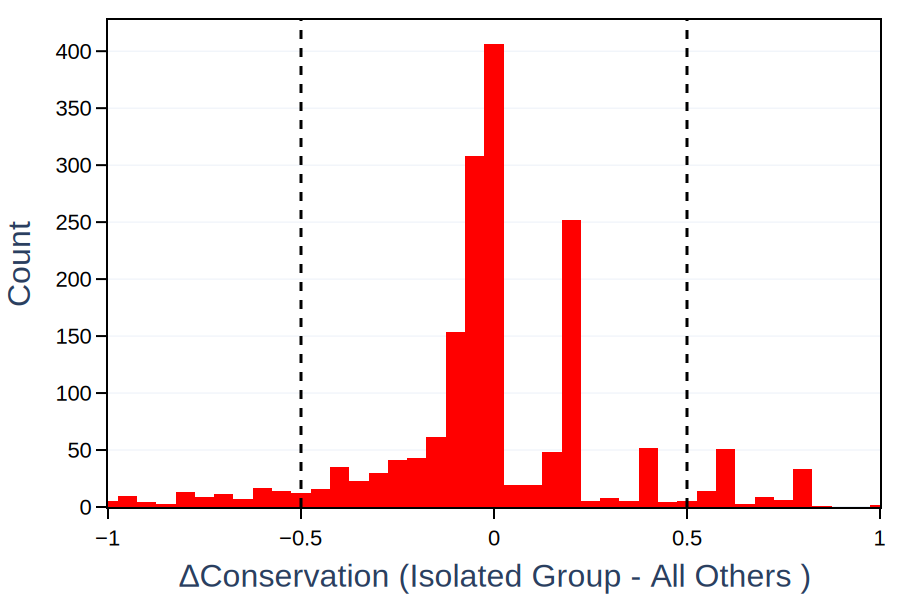

In [19]:
fig = px.histogram(x=list(cluster_diffs.values()), nbins=50, color_discrete_sequence=["red"])

fig.update_layout(
    template="plotly_white",
    yaxis=dict(title="Count", titlefont=dict(size=32)),
    xaxis=dict(title="ΔConservation (Isolated Group - All Others )", titlefont=dict(size=32)),
    margin=dict(l=20, r=20, t=20, b=20),
    showlegend=False,
    font_family="Arial",
    width=900,
    height=600,
    xaxis_range=[-1.0,1.0]
)

fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True,
                 ticks="outside", tickwidth=2, tickcolor='black', ticklen=10,
                 #tickvals = [-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5],
                 tickfont=dict(color='black', size=22))
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True,
                 ticks="outside", tickwidth=2, tickcolor='black', ticklen=10,
                 tickfont=dict(color='black', size=22))

fig.add_vline(x=0.5, line_width=3, line_dash="dash", line_color="black")
fig.add_vline(x=-0.5, line_width=3, line_dash="dash", line_color="black")
pio.write_image(fig, r"comparison_results/Hist_cluster_contact_diffs_Supp_Info.png", scale=6)
fig.show("svg") # remove "svg" to make the figure interactive.

In [20]:
# use a cutoff of 0.5, find best represenatives to project results onto.
count_not_included, count_included = 0, 0
most_diff_stronger, others_stronger = {}, {}
for msa_pair, diff in cluster_diffs.items():
    if diff > 0.8: # stronger in isolated group
        most_diff_stronger[msa_pair] = diff
        count_included += 1
    elif diff < -0.8: # stronger in all others.
        others_stronger[msa_pair] = diff
        count_included += 1
    else:
        count_not_included += 1

print(count_included, count_not_included)

25 1733


In [21]:
others_df = all_msa_contacts[all_msa_contacts["New Clusters"] == "All Others"]
most_diff_df = all_msa_contacts[all_msa_contacts["New Clusters"] == "Most Diff"]

others_matches = {}
for _, protein_row in others_df.iterrows():
    protein = protein_row["protein"]
    match_count = 0
    for msa_pair in list(others_stronger.keys()):
        match_count += protein_row[msa_pair] # value is 1 or 0 depending on if exists.
    others_matches[protein] = match_count
others_matches  = {k: v for k, v in sorted(others_matches.items(), key=lambda item: item[1], reverse=True)} # sort by value

most_diff_matches = {}
for _, protein_row in most_diff_df.iterrows():
    protein = protein_row["protein"]
    match_count = 0
    for msa_pair in list(most_diff_stronger.keys()):
        match_count += protein_row[msa_pair] # value is 1 or 0 depending on if exists.
    most_diff_matches[protein] = match_count
most_diff_matches  = {k: v for k, v in sorted(most_diff_matches.items(), key=lambda item: item[1], reverse=True)} # sort by value

f"{len(others_matches)=},  {len(most_diff_matches)=}"

'len(others_matches)=64,  len(most_diff_matches)=5'

now make the pymol projections 

In [22]:
others_rep_pdb = "1HTZ_TEM-52"
most_diff_rep_pdb = "1E25_PER-1"
# absolute value needed for pymol projections.
others_stronger = {key: np.abs(value) for key, value in others_stronger.items()}

In [23]:
# others
others_res_res_scores, others_res_res_colors = {}, {}
for msa_pair, diff in others_stronger.items():
    msa_res1, msa_res2 = msa_pair
    try:
        contact_row = all_msa_contacs_dfs[others_rep_pdb].query(f"Res1_msa == {msa_res1} & Res2_msa == {msa_res2} & not Interaction_Type.str.contains('vdw')").iloc[0]
    except IndexError:
        # protein does not have all the msa_contacts, just most of them,
        # expected behaviour.
        continue
    res1, res2, interaction_type = contact_row[["Res1_pdb", "Res2_pdb", "Interaction_Type"]]
    res1_numb = int(re.search(r"\d+", res1).group())
    res2_numb = int(re.search(r"\d+", res2).group())

    others_res_res_scores[(res1_numb, res2_numb)] = diff
    others_res_res_colors[(res1_numb, res2_numb)] = PYMOL_COLOR_SCHEME[interaction_type]


# most_diff
most_diff_res_res_scores, most_diff_res_res_colors = {}, {}
for msa_pair, diff in most_diff_stronger.items():
    msa_res1, msa_res2 = msa_pair
    try:
        contact_row = all_msa_contacs_dfs[most_diff_rep_pdb].query(f"Res1_msa == {msa_res1} & Res2_msa == {msa_res2} & not Interaction_Type.str.contains('vdw')").iloc[0]
    except IndexError:
        # protein does not have all the msa_contacts, just most of them,
        # expected behaviour.
        continue
    res1, res2, interaction_type = contact_row[["Res1_pdb", "Res2_pdb", "Interaction_Type"]]
    res1_numb = int(re.search(r"\d+", res1).group())
    res2_numb = int(re.search(r"\d+", res2).group())

    most_diff_res_res_scores[(res1_numb, res2_numb)] = diff
    most_diff_res_res_colors[(res1_numb, res2_numb)] = PYMOL_COLOR_SCHEME[interaction_type]

In [24]:
# save pymol files
project_pymol_res_res_scores(
    res_res_scores=others_res_res_scores,
    out_file=r"comparison_results/pymol_stronger_other_res.pml",
    res_res_colors=others_res_res_colors,
)

project_pymol_res_res_scores(
    res_res_scores=most_diff_res_res_scores,
    out_file=r"comparison_results/pymol_stronger_most_diff.pml",
    res_res_colors=most_diff_res_res_colors,
)

The file: comparison_results/pymol_stronger_other_res.pml was written to disk.
The file: comparison_results/pymol_stronger_most_diff.pml was written to disk.
